<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()


#  Data Augmentation
def load_dataset(batch_size=64):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    train_data = datasets.SVHN(root="./data", split='train', download=True, transform=transform)
    val_data = datasets.SVHN(root="./data", split='test', download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_dataset()


In [ ]:
# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Training Function with Optimized Hyperparameters
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1, images.size(2))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_acc = 100 * correct / total
        history['loss'].append(total_loss / len(train_loader))
        history['accuracy'].append(train_acc)
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_labels, val_predictions, val_probs = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1, images.size(2))
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                val_labels.extend(labels.cpu().numpy())
                val_predictions.extend(predicted.cpu().numpy())
                val_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        val_acc = 100 * val_correct / val_total
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_acc)
        precision = precision_score(val_labels, val_predictions, average='macro', zero_division=0)
        recall = recall_score(val_labels, val_predictions, average='macro', zero_division=0)
        f1 = f1_score(val_labels, val_predictions, average='macro', zero_division=0)
        auc = roc_auc_score(val_labels, val_probs, multi_class='ovo', average='macro')
        print(f"Epoch {epoch+1}/{epochs}: Accuracy: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {auc:.4f}")
    return model, history


In [ ]:
# Visualization Function
def plot_metrics(history, model_name):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Model Loss')
    plt.legend()
    plt.show()


In [ ]:
# Training Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size, hidden_size, output_size, num_layers = 32, 512, 10, 2
epochs, learning_rate = 20, 0.0005

criterion = nn.CrossEntropyLoss()

# Train RNN Model
print("Training RNN Model...")
rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers).to(device)
rnn_optimizer = optim.AdamW(rnn_model.parameters(), lr=learning_rate, weight_decay=1e-5)
rnn_model, rnn_history = train_model(rnn_model, train_loader, val_loader, criterion, rnn_optimizer, device, epochs)

# Plot RNN Metrics
plot_metrics(rnn_history, "RNN")


Training RNN Model...


In [ ]:
# Train LSTM Model
print("Training LSTM Model...")
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
lstm_optimizer = optim.AdamW(lstm_model.parameters(), lr=learning_rate)
lstm_model, lstm_history = train_model(lstm_model, train_loader, val_loader, criterion, lstm_optimizer, device, epochs)

# Plot LSTM Metrics
plot_metrics(lstm_history, "LSTM")

In [ ]:
# Train GRU Model
print("Training GRU Model...")
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)
gru_optimizer = optim.AdamW(gru_model.parameters(), lr=learning_rate)
gru_model, gru_history = train_model(gru_model, train_loader, val_loader, criterion, gru_optimizer, device, epochs)

# Plot GRU Metrics
plot_metrics(gru_history, "GRU")

# Tensorflow

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

In [ ]:
# Set random seed for reproducibility
def set_seed(seed=42):
    tf.random.set_seed(seed)

set_seed()

def load_tf_dataset(batch_size=64):
    dataset, info = tfds.load("svhn_cropped", split=['train', 'test'], as_supervised=True, with_info=True)
    train_data, test_data = dataset

    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = (image - 0.5) / 0.5
        image = tf.reshape(image, (32, 32))  # Reshape to (timesteps=32, features=32)
        return image, label


    train_data = train_data.map(preprocess).batch(batch_size).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)
    test_data = test_data.map(preprocess).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return train_data, test_data

train_data, test_data = load_tf_dataset()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.IQBJG9_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.IQBJG9_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.IQBJG9_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


In [ ]:
# Define RNN Model (TensorFlow)
class RNNModel(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=False)
        self.fc = tf.keras.layers.Dense(output_size, activation='softmax')

    def call(self, x):
        x = self.rnn(x)
        return self.fc(x)

# Define LSTM Model (TensorFlow)
class LSTMModel(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=False)
        self.fc = tf.keras.layers.Dense(output_size, activation='softmax')

    def call(self, x):
        x = self.lstm(x)
        return self.fc(x)

# Define GRU Model (TensorFlow)
class GRUModel(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = tf.keras.layers.GRU(hidden_size, return_sequences=False)
        self.fc = tf.keras.layers.Dense(output_size, activation='softmax')

    def call(self, x):
        x = self.gru(x)
        return self.fc(x)



In [ ]:
# Define Training and Evaluation Function for TensorFlow Models
def train_tf_model(model, dataset, epochs=10):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(dataset, epochs=epochs, verbose=1)
    return history

def evaluate_model(model, dataset):
    y_true, y_pred, y_prob = [], [], []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        y_prob.extend(preds)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(tf.keras.utils.to_categorical(y_true, num_classes=10), y_prob, multi_class='ovr')

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")

    return precision, recall, f1, auc


In [ ]:
# Training and Evaluating Models
hidden_size = 128
output_size = 10
epochs = 10

rnn_model = RNNModel(hidden_size, output_size)
lstm_model = LSTMModel(hidden_size, output_size)
gru_model = GRUModel(hidden_size, output_size)

print("Training RNN Model...")
rnn_history = train_tf_model(rnn_model, train_data, epochs)
print("Evaluating RNN Model...")
evaluate_model(rnn_model, test_data)

print("Training LSTM Model...")
lstm_history = train_tf_model(lstm_model, train_data, epochs)
print("Evaluating LSTM Model...")
evaluate_model(lstm_model, test_data)

print("Training GRU Model...")
gru_history = train_tf_model(gru_model, train_data, epochs)
print("Evaluating GRU Model...")
evaluate_model(gru_model, test_data)

Training RNN Model...
Epoch 1/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - accuracy: 0.3114 - loss: 1.9864
Epoch 2/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.5753 - loss: 1.3061
Epoch 3/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.6546 - loss: 1.0934
Epoch 4/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.6925 - loss: 0.9796
Epoch 5/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.7124 - loss: 0.9193
Epoch 6/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.7279 - loss: 0.8815
Epoch 7/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.7432 - loss: 0.8334
Epoch 8/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.7469 - loss: 0.8234
Epoch 9/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.7510 - loss: 0.8078
Epoch 10/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7535 - loss: 0.7943
Evaluating RNN Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
2/2 ━━━━━━━━━━

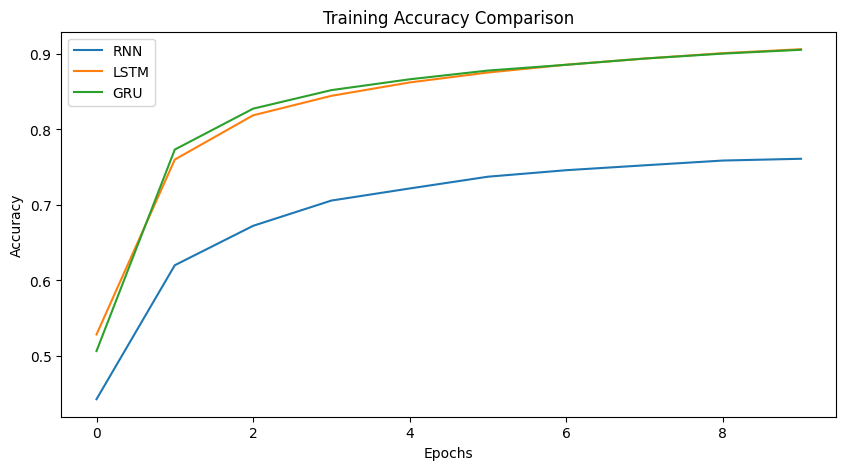

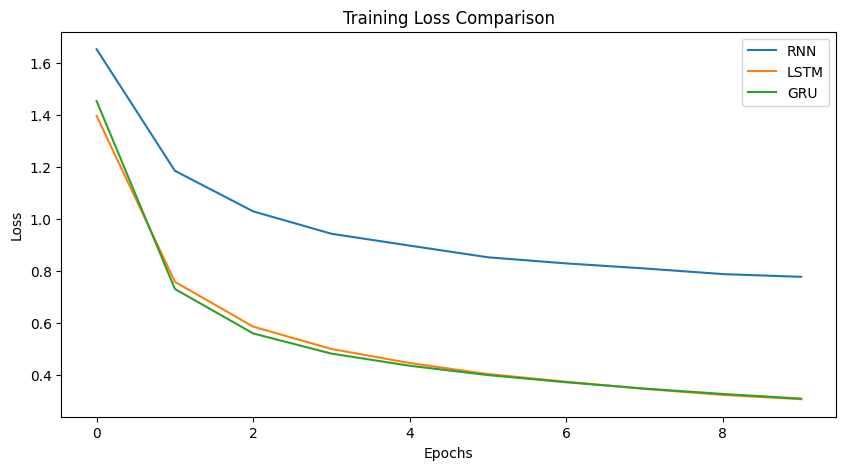

In [ ]:
# Plot Training Accuracy
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['accuracy'], label='RNN')
plt.plot(lstm_history.history['accuracy'], label='LSTM')
plt.plot(gru_history.history['accuracy'], label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.show()

# Plot Training Loss
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['loss'], label='RNN')
plt.plot(lstm_history.history['loss'], label='LSTM')
plt.plot(gru_history.history['loss'], label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()
